In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")

# Import

In [4]:
import numpy as np
import pandas as pd
from rdkit import Chem

In [11]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
np.random.seed(0)

<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [6]:
from skfp.fingerprints import MACCSFingerprint

In [18]:
from matplotlib import pyplot as plt
def plot_scatter_with_metrics_(Xs, ys, title=None, min_=-10, max_=60, figsize = (5,5), colors=['r', "b", "g"]):
    plt.figure(figsize=figsize, facecolor='white')
    plt.xlim(min_, max_)
    plt.ylim(min_, max_)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    z = np.linspace(min_, max_, 10000)
    plt.plot(z, z)
    for x_id, [x, y] in enumerate(zip(Xs, ys)):
       plt.scatter(x, y, marker="*", c=colors[x_id])
    plt.savefig("test.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

In [19]:
def draw_heatmap(x_labels=[], y_labels=[], values=None, title=None, figure_size=(40, 6), colors='Blues'):
    import seaborn as sns
    plt.rcParams['font.sans-serif']='Arial'
    uniform_data = values
    f, ax = plt.subplots(figsize=figure_size, dpi=300)
    annot_kws = {"fontsize": 30}
    min_value = np.min(values)
    max_value = np.max(values)
    sns.heatmap(uniform_data, ax=ax,vmin=min_value,vmax=max_value,cmap=colors,linewidths=2,cbar=1, annot=True,annot_kws=annot_kws, fmt='.3f')
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)
    if title!= None: ax.set_title(title, fontsize=40)
    if x_labels!= None: 
        ax.set_xticklabels(x_labels, fontsize=30)
        label_x =  ax.get_xticklabels()
        plt.setp(label_x, rotation=0, horizontalalignment='center')
    if y_labels!= None: 
        ax.set_yticklabels(y_labels, fontsize=30)
        label_y =  ax.get_yticklabels()
        plt.setp(label_y, rotation=0, horizontalalignment='right')
    plt.savefig('test.png', dpi=300, bbox_inches = 'tight' )
    plt.show()
    return plt

# Load Data and Generate Descriptors

In [7]:
all_df_unique = pd.read_csv("Data.csv")
target = all_df_unique['ee']
smiles_list = all_df_unique['Ligand SMILES'].tolist()
fps = MACCSFingerprint.transform(MACCSFingerprint(), smiles_list)
fps = np.nan_to_num(fps, nan=0)
print(fps.shape)

(81, 166)


# Additional Descriptors

In [8]:
subsmiles_list = [    "C12N=COC1CC3=CC=CC=C23",
                      "C1(CC2=NC(C3=CC=CC=C3)CO2)=NC(C4=CC=CC=C4)CO1",
                      "C1(CC2=NC(C3=CC=CC=C3)C(C4=CC=CC=C4)O2)=NC(C5=CC=CC=C5)C(C6=CC=CC=C6)O1", 
                      "C1(C2=CC=CC=C2)N=COC1",
                      "C1(C2=CC=CC=C2)CN=CO1",
                      "C1(C2=CC=CC=C2)N=COC1C3=CC=CC=C3", 
                      "C1(CC2=NC3C4=C(C=CC=C4)CC3O2)=NC5C6=CC=CC=C6CC5O1",
                      "CCCC(C1=NCCO1)C2=NCCO2",
                      "CCC(C1=NCCO1)C2=NCCO2",
                      "C1(C2(CC2)C3=NCCO3)=NCCO1",
                      "C1(C2(CCC2)C3=NCCO3)=NCCO1",
                      "C1(C2(CCCC2)C3=NCCO3)=NCCO1",
                      "C1(C2(CCCCC2)C3=NCCO3)=NCCO1",
                      "C1(C2(CCCCCC2)C3=NCCO3)=NCCO1",
                      "C1(C2(CC(C=CC=C3)=C3C2)C4=NCCO4)=NCCO1",
                      "C1(C(C2=NCCO2)CC3=CC=CC=C3)=NCCO1",
                      "C1(C(C2=NCCO2)(CC3=CC=CC=C3)CC4=CC=CC=C4)=NCCO1",
                      "Cc1ccc(C23CC4CC(CC(C4)C3)C2)cc1", 
                      "BrCCCCCCC",
                      "Brc1ccc2c(C3N=COC3C2)c1",
                      "C12N=COC1Cc3c2cc(c(cc4)cc5c4cccc5)cc3",
                      "CC1=NC2c3c(CC2O1)ccc(c(ccc4)c5c4cccc5)c3",
                      "CC(C)(c1ccc(C)cc1)C",
                      "CC(C)(c1c(C)cccc1)C",
                      "CCC(C)(c1ccc(C)cc1)C",
                      "CC(C)Cc1ccc(C)cc1",
                      "CCCCC1=CC=C(C)C=C1",
                      "Cc1cc(C(F)(F)F)cc(C(F)(F)F)c1",
                      "Cc1cc(C)c(c2cc(C3N=COC3C4)c4cc2)c(C)c1",
                      "Cc(cc1)cc2c1cccc2",
                      "FC(F)F",
                      "C12CC3CC(C2)CC(C1)C3",
                      "CC(C)C"
                      ]

In [9]:
all_Xs = []
for mol_id, [smiles, fps_] in enumerate(zip(smiles_list, fps[:, ])):
    des = []
    mol = Chem.MolFromSmiles(smiles)
    for subsmiles in subsmiles_list:
        if mol.HasSubstructMatch(Chem.MolFromSmiles(subsmiles)):
            des += [1]
        else:
            des += [0]
    des += fps_.tolist()
    all_Xs.append(des)
all_Xs = np.array(all_Xs)
keeped_index = [idx for idx, each in enumerate(all_Xs.sum(axis=0)) if each not in [0, len(all_Xs)]]
print(keeped_index)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 43, 51, 54, 74, 78, 94, 106, 119, 133, 137, 138, 139, 140, 141, 143, 146, 147, 148, 150, 155, 157, 158, 160, 161, 164, 166, 168, 170, 172, 173, 176, 177, 178, 179, 181, 182, 184, 185, 186, 187, 192, 194, 195]


In [ ]:
def feature_selection(X, y, train, test):
    remain_list = []
    all_list = list(range(len(X[0])))
    for idx in range(len(X[0])):
        all_r2 = []
        for id, each in enumerate(all_list):
            print(id, len(all_list), end='\r')
            if each in remain_list:
                all_r2.append(-10)
                continue
            else:
                temp_remain_list = remain_list + [each]
            X_new = X[:, temp_remain_list]
            temp_r2 = []
            kfold = KFold(n_splits=5, shuffle=True, random_state=0)
            
            model = CatBoostRegressor(iterations=100, random_state=0)
            # model = GradientBoostingRegressor(n_estimators=100, random_state=0)
            # model = RandomForestRegressor(n_estimators=100, random_state=0)
            # model = XGBRegressor(n_estimators=100, random_state=0)
            # model = LinearRegression()
            acc = cross_val_score(model, X_new[train], y[train], cv=kfold, n_jobs=-1).mean()
            temp_r2 = acc.mean()
            all_r2.append(temp_r2)
        max_id = np.argmax(all_r2)
        if max_id in remain_list:
            remain_list.remove(max_id)
        else:
            remain_list.append(max_id)
        print(np.max(all_r2), remain_list)
    return all_r2, remain_list
all_r2, y_in_removed_lists = feature_selection(np.array(all_Xs[:, keeped_index]), target, np.arange(len(all_Xs[:, keeped_index])), [])

In [ ]:
# Add Our Fingerprint 
# keeped_index [10, 18, 21, 41, 45, 61, 73, 86, 100, 104, 105, 106, 107, 108, 110, 113, 114, 115, 117, 122, 124, 125, 127, 128, 131, 133, 135, 137, 139, 140, 143, 144, 145, 146, 148, 149, 151, 152, 153, 154, 159, 161, 162]
# CB 0.8064732214108276 [10, 24, 35, 39, 3, 5, 6, 0, 19]
# GB 0.7940629373660777 [24, 35, 39, 1, 5, 0, 29, 15, 19, 40, 21, 10, 26, 20, 28, 31, 34, 36, 38, 41, 27, 42]
# RF 0.7936708287488877 [24, 35, 39, 5, 29, 1, 10, 36, 15, 20, 19, 21, 34, 0, 2, 32]
# XGB 0.7849371790885925 [24, 35, 39, 1, 36, 0, 32, 13, 14, 19, 20, 21, 26, 28, 31, 38, 41, 42, 27, 37, 10, 3, 8, 9, 30, 5, 6]
# Linear 0.7388133052175508 [24, 13, 39, 35, 6, 19, 0, 1, 16, 12, 32, 14, 20, 21, 26, 28, 31, 41, 38, 42, 36, 5, 10]

# keeped_index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 43, 51, 54, 74, 78, 94, 106, 119, 133, 137, 138, 139, 140, 141, 143, 146, 147, 148, 150, 155, 157, 158, 160, 161, 164, 166, 168, 170, 172, 173, 176, 177, 178, 179, 181, 182, 184, 185, 186, 187, 192, 194, 195]
# CB 0.90242543737931 [18, 0, 67, 25, 21, 37, 22, 8, 64, 6, 2, 17, 11, 44]
# GB 0.8833015459507163 [0, 67, 25, 71, 21, 29, 23, 22, 27, 37, 10, 13, 64, 2, 19, 52, 18, 17]
# RF 0.8765474226798196 [0, 67, 25, 21, 37, 22, 64, 13, 23, 8, 27, 29, 16, 44, 68, 24, 30, 18, 52, 17, 59, 31, 6, 26, 42, 56, 63]
# XGB 0.8949560642242431 [0, 67, 25, 21, 22, 37, 44, 64, 13, 17, 45, 51, 6, 26, 31, 33, 46, 52, 53, 56, 58, 60, 63, 70, 73, 74, 23, 2, 4, 5, 28, 18]
# Linear 0.8286625384602093 [0, 45, 25, 21, 24, 28, 10, 13, 64, 29, 67, 27, 61, 39, 6, 2, 51, 56]

In [ ]:
results = [[0.8064732214108276, 0.7940629373660777, 0.7936708287488877, 0.7849371790885925, 0.7388133052175508],
           [0.90242543737931, 0.8833015459507163, 0.8765474226798196, 0.8949560642242431, 0.8270200855834717]]


In [ ]:
draw_heatmap(values=results, figure_size=(12, 2))

In [ ]:
keeped_index = [10, 18, 21, 41, 45, 61, 73, 86, 100, 104, 105, 106, 107, 108, 110, 113, 114, 115, 117, 122, 124, 125, 127, 128, 131, 133, 135, 137, 139, 140, 143, 144, 145, 146, 148, 149, 151, 152, 153, 154, 159, 161, 162]
select_descriptor_id = [24, 13, 39, 35, 6, 19, 0, 1, 16, 12, 32, 14, 20, 21, 26, 28, 31, 41, 38, 42, 36, 5, 10]
indexs = np.array(keeped_index)[select_descriptor_id]
# all_X_ = all_Xs[:, indexs]
all_X_ = fps[:, indexs]
target_ = target
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf = list(kf.split(all_Xs))
all_r2 = []
all_mae = []
all_pred = np.zeros(target_.shape)
for train_id, test_id in kf:
    X_train, X_test = all_X_[train_id], all_X_[test_id]
    y_train, y_test = target_[train_id], target_[test_id]
    model = CatBoostRegressor(iterations=100, random_state=0)
    # model = GradientBoostingRegressor(n_estimators=100, random_state=0)
    # model = RandomForestRegressor(n_estimators=100, random_state=0)
    # model = XGBRegressor(n_estimators=100, random_state=0)
    # model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    all_r2.append(r2_score(y_test, y_pred))
    all_mae.append(mean_absolute_error(y_test, y_pred))
    all_pred[test_id] = y_pred
    
print("Average R2: ", np.mean(all_r2))
print("Average MAE: ", np.mean(all_mae))

In [16]:
all_mols = [Chem.MolFromSmiles(each) for each in smiles_list]
four_mol_ids =[idx for idx, mol in enumerate(all_mols) if len(mol.GetSubstructMatch(Chem.MolFromSmiles("c1(CC(C2=NC3c4c(CC3O2)cccc4)(C5=NC6c7c(CC6O5)cccc7)Cc8ccccc8)ccccc1"))) > 0]
two_mol_ids = [idx for idx, mol in enumerate(all_mols) if len(mol.GetSubstructMatch(Chem.MolFromSmiles("C1(CC2=N[C@H]3c4c(C[C@H]3O2)cccc4)=N[C@H]5c6c(C[C@H]5O1)cccc6"))) > 0 and idx not in four_mol_ids]
special_mols_idxs = four_mol_ids + two_mol_ids
other_mols_idxs = [idx for idx, mol in enumerate(all_mols) if idx not in special_mols_idxs]
print(len(four_mol_ids), len(two_mol_ids), len(other_mols_idxs))

29 11 41


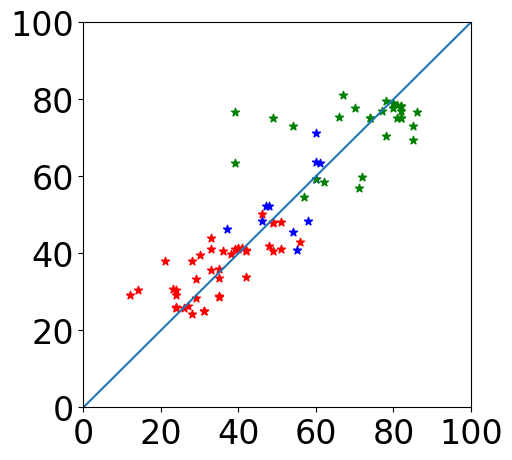

In [20]:
plot_scatter_with_metrics_([target[other_mols_idxs], target[two_mol_ids], target[four_mol_ids]], [all_pred[other_mols_idxs], all_pred[two_mol_ids], all_pred[four_mol_ids]], max_=100, min_=0, )